In [4]:
%matplotlib inline

import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
#import imageio as im
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [5]:
classifier = Sequential()

classifier.add(Conv2D(32, (3, 3), padding='same', input_shape = (28, 28, 3), activation = 'relu'))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25

# Adding a third convolutional layer
classifier.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 512, activation = 'relu'))
classifier.add(Dropout(0.5)) 
classifier.add(Dense(units = 3, activation = 'softmax'))

classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
__________

In [6]:
classifier.compile(optimizer = 'rmsprop',
                   loss = 'categorical_crossentropy', 
                   metrics = ['accuracy'])

In [27]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('basicshapes/training',
                                                 target_size = (28, 28),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('basicshapes/test',
                                            target_size = (28, 28),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 210 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


In [7]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

In [15]:
history = classifier.fit_generator(training_set,
                                   steps_per_epoch = 100,
                                   epochs = 10,
                                   callbacks=[checkpointer],
                                   validation_data = test_set,
                                   validation_steps = 50)

Epoch 1/10
100/100 [==============================] - 11s 113ms/step - loss: 0.0723 - acc: 0.9807 - val_loss: 1.3429 - val_acc: 0.8914

Epoch 00001: val_acc did not improve from 0.90027
Epoch 2/10
100/100 [==============================] - 15s 146ms/step - loss: 0.0566 - acc: 0.9900 - val_loss: 1.1045 - val_acc: 0.8577

Epoch 00002: val_acc did not improve from 0.90027
Epoch 3/10
100/100 [==============================] - 13s 130ms/step - loss: 0.0916 - acc: 0.9806 - val_loss: 1.2233 - val_acc: 0.8684

Epoch 00003: val_acc did not improve from 0.90027
Epoch 4/10
100/100 [==============================] - 16s 158ms/step - loss: 0.0688 - acc: 0.9844 - val_loss: 0.5488 - val_acc: 0.9223

Epoch 00004: val_acc improved from 0.90027 to 0.92225, saving model to best_weights.hdf5
Epoch 5/10
100/100 [==============================] - 17s 168ms/step - loss: 0.0908 - acc: 0.9812 - val_loss: 0.7620 - val_acc: 0.8896

Epoch 00005: val_acc did not improve from 0.92225
Epoch 6/10
100/100 [===========

In [18]:
classifier.load_weights('best_weights.hdf5')
classifier.save('shapes_cnn.h5')

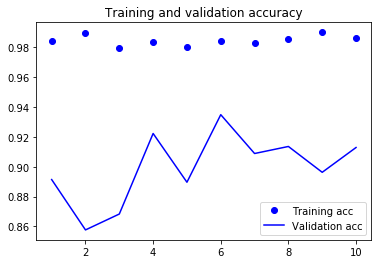

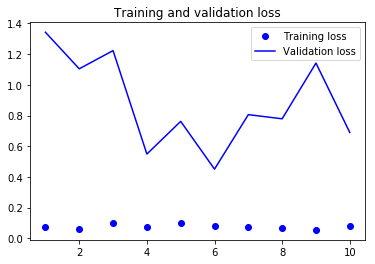

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

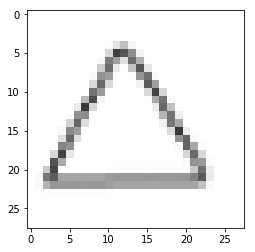

(1, 28, 28, 3)


In [20]:
img_path = 'basicshapes/test/triangles/drawing(2).png'

img = image.load_img(img_path, target_size=(28, 28))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

In [21]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = classifier.predict_classes(images, batch_size=10)
print("Predicted class is:",classes)

Predicted class is: [2]


In [22]:
layer_outputs = [layer.output for layer in classifier.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=classifier.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

(1, 28, 28, 32)


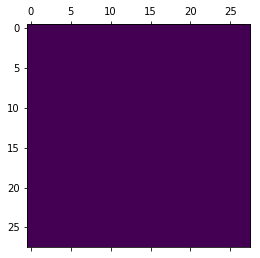

In [23]:
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation
first_layer_activation = activations[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

/media/anik/34BA9D8DBA9D4C6C/phd/virtual_projects/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


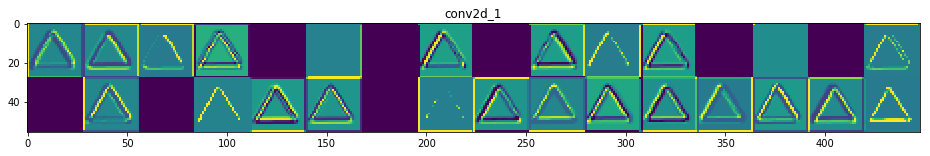

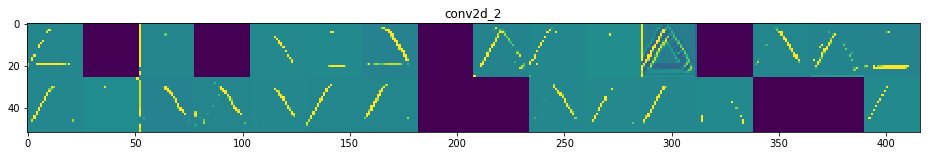

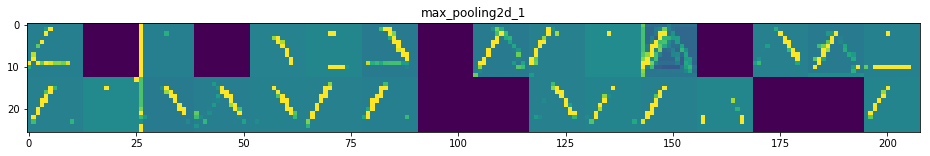

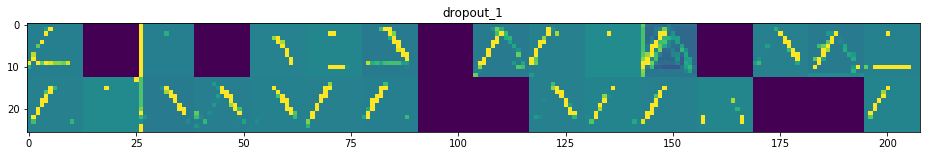

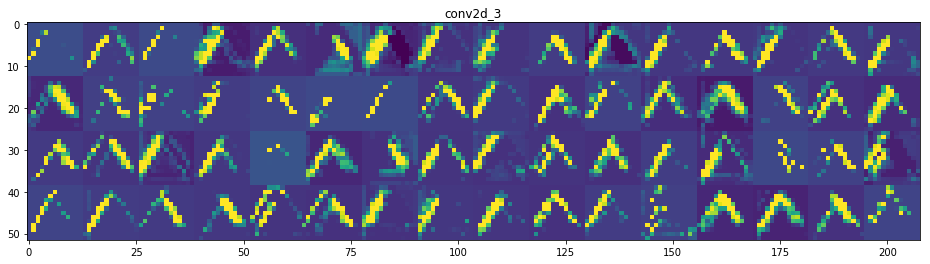

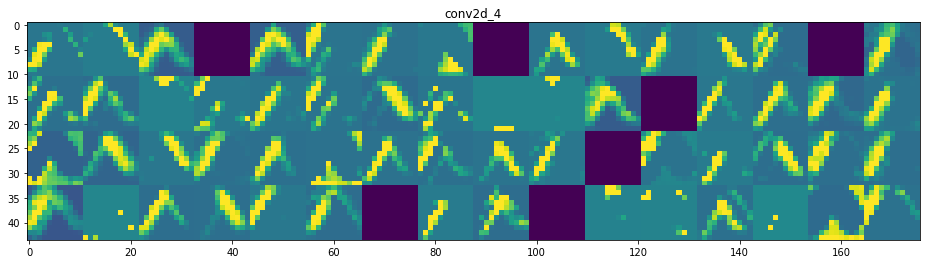

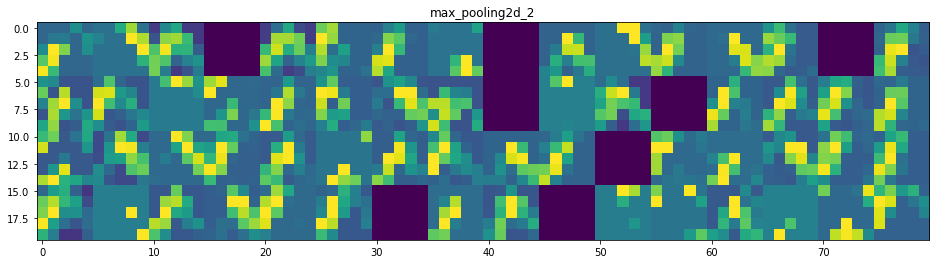

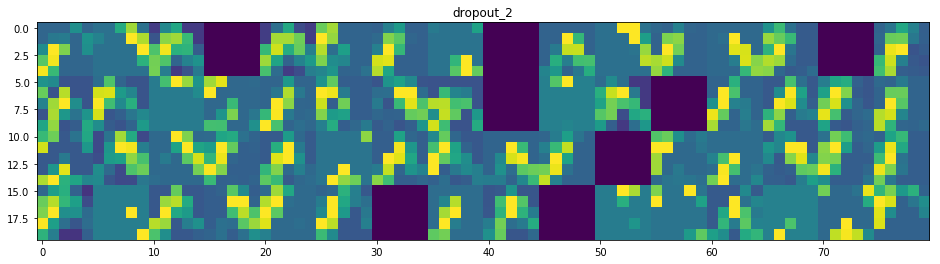

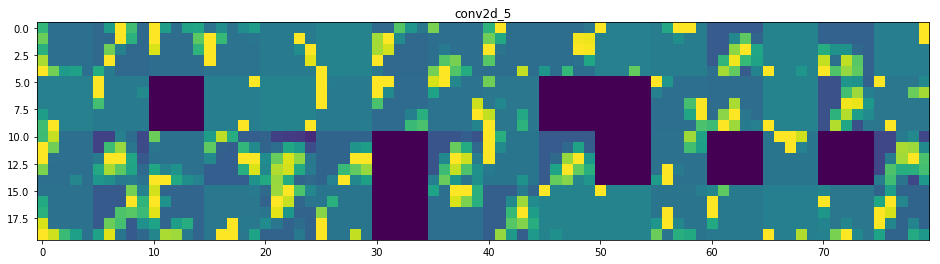

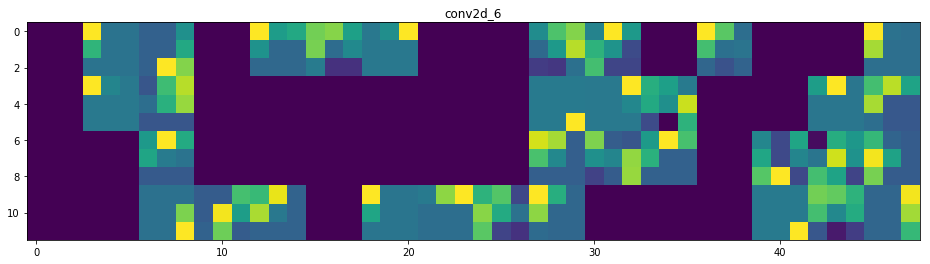

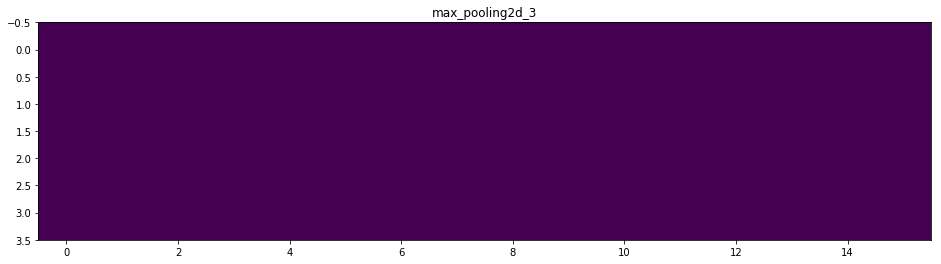

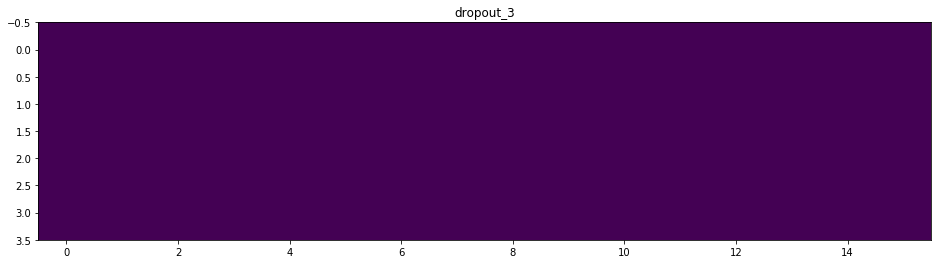

In [24]:
layer_names = []
for layer in classifier.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')